In [6]:
import sys

sys.path.insert(0, '../..')

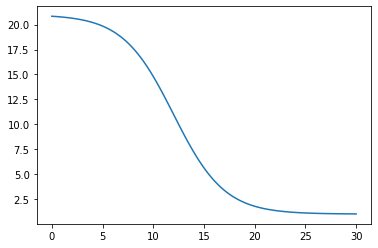

In [108]:

def sigmoid(x, a, kd, n, offset, inv):
    return a - a / (1.0 + np.exp((-x + kd) * n * inv)) + offset

x = np.linspace(0, 30, 100)
y = sigmoid(x, 20, 12, 0.4, 1, 1)

plt.plot(x, y)

In [122]:
from caldera.data import *
from caldera.gnn.blocks import *
from caldera.gnn.models import *
from caldera.utils import nx_utils
import numpy as np
import networkx as nx
import torch
import functools

class DataLoaders:
    @staticmethod
    def _default_g(g: nx.DiGraph):
        for _, data in g.nodes(data=True):
            data["features"] = np.zeros((1,))
            data["target"] = np.zeros((1,))

        for _, _, data in g.edges(data=True):
            data["features"] = np.zeros((1,))
            data["target"] = np.zeros((1,))

        g.data = {"features": np.zeros((1,)), "target": np.zeros((1,))}
        return g

    @classmethod
    def sigmoid_circuit(cls, data_size, batch_size):
        import math

        def func(x):
            return sigmoid(x, 12, 12, 0.4, 1, 1)
#             return 1 - 1.0 / (1 + math.exp(-x))

        input_data = []
        output_data = []
        for _ in range(data_size):
            n_size = np.random.randint(5, 20)
            tree = nx.random_tree(n_size)

            # randomize node directions
            g = nx.DiGraph()
            for n1, n2, edata in tree.edges(data=True):
                i = np.random.randint(2)
                if i % 2 == 0:
                    g.add_edge(n1, n2)
                else:
                    g.add_edge(n2, n1)
            cls._default_g(g)

            for n in nx_utils.iter_roots(g):
                ndata = g.nodes[n]

            for n in nx.topological_sort(g):
                ndata = g.nodes[n]
                if "out" not in ndata:
                    incoming = []
                    for p in g.predecessors(n):
                        pdata = g.nodes[p]
                        incoming.append(pdata["out"])
                    incoming = np.array(incoming)
                    if not len(incoming):
                        i = 0
                    else:
                        i = incoming.sum()
                    o = func(i)
                    ndata["out"] = o
                    
            for n, ndata in g.nodes(data=True):
                ndata['target'] = np.array([ndata['out']])
                    

            input_data.append(GraphData.from_networkx(g, feature_key="features"))
            output_data.append(GraphData.from_networkx(g, feature_key="target"))

        return GraphDataLoader(
            list(zip(input_data, output_data)), batch_size=batch_size
        )
    
l = DataLoaders.sigmoid_circuit(10, 10)

In [133]:
from typing import List

import torch
from torch import nn

from caldera.gnn.blocks import AggregatingEdgeBlock
from caldera.gnn.blocks import AggregatingGlobalBlock
from caldera.gnn.blocks import AggregatingNodeBlock
from caldera.gnn.blocks import MultiAggregator
from caldera.gnn.blocks import EdgeBlock
from caldera.gnn.blocks import Flex
from caldera.gnn.blocks import GlobalBlock
from caldera.gnn.blocks import Dense
from caldera.gnn.blocks import NodeBlock
from caldera.data import GraphBatch
from caldera.gnn.models import GraphCore
from caldera.gnn.models import GraphEncoder
from caldera.utils import pairwise


class Network(torch.nn.Module):
    def __init__(
        self,
        latent_sizes=(128, 128, 1),
        depths=(1, 1, 1),
        dropout: float = None,
        pass_global_to_edge: bool = True,
        pass_global_to_node: bool = True,
        node_block_aggregator=tuple(['add', 'max', 'mean', 'min']),
        global_block_to_node_aggregator=tuple(['add', 'max', 'mean', 'min']),
        global_block_to_edge_aggregator=tuple(['add', 'max', 'mean', 'min']),
    ):
        super().__init__()
        self.config = {
            "latent_size": {
                "node": latent_sizes[1],
                "edge": latent_sizes[0],
                "global": latent_sizes[2],
                "core_node_block_depth": depths[0],
                "core_edge_block_depth": depths[1],
                "core_global_block_depth": depths[2],
            },
            "node_block_aggregator": node_block_aggregator,
            "global_block_to_node_aggregator": global_block_to_node_aggregator,
            "global_block_to_edge_aggregator": global_block_to_edge_aggregator,
            "pass_global_to_edge": pass_global_to_edge,
            "pass_global_to_node": pass_global_to_node,
        }
        self.encoder = GraphEncoder(
            EdgeBlock(Flex(Dense)(Flex.d(), latent_sizes[0], dropout=dropout)),
            NodeBlock(Flex(Dense)(Flex.d(), latent_sizes[1], dropout=dropout)),
            GlobalBlock(Flex(Dense)(Flex.d(), latent_sizes[2], dropout=dropout)),
        )

        edge_layers = [self.config["latent_size"]["edge"]] * self.config["latent_size"][
            "core_edge_block_depth"
        ]
        node_layers = [self.config["latent_size"]["node"]] * self.config["latent_size"][
            "core_node_block_depth"
        ]
        global_layers = [self.config["latent_size"]["global"]] * self.config[
            "latent_size"
        ]["core_global_block_depth"]

        self.core = GraphCore(
            AggregatingEdgeBlock(
                torch.nn.Sequential(
                    Flex(Dense)(Flex.d(), *edge_layers, dropout=dropout, layer_norm=True),
                    # Flex(torch.nn.Linear)(Flex.d(), edge_layers[-1])
                )
            ),
            AggregatingNodeBlock(
                torch.nn.Sequential(
                    Flex(Dense)(Flex.d(), *node_layers, dropout=dropout, layer_norm=True),
                    # Flex(torch.nn.Linear)(Flex.d(), node_layers[-1])
                ),
                Flex(MultiAggregator)(Flex.d(), self.config["node_block_aggregator"]),
            ),
            AggregatingGlobalBlock(
                torch.nn.Sequential(
                    Flex(Dense)(Flex.d(), *global_layers, dropout=dropout, layer_norm=True),
                    # Flex(torch.nn.Linear)(Flex.d(), global_layers[-1])
                ),
                edge_aggregator=Flex(MultiAggregator)(
                    Flex.d(),
                    self.config["global_block_to_edge_aggregator"]
                ),
                node_aggregator=Flex(MultiAggregator)(
                    Flex.d(),
                    self.config["global_block_to_node_aggregator"]
                ),
            ),
            pass_global_to_edge=self.config["pass_global_to_edge"],
            pass_global_to_node=self.config["pass_global_to_node"],
        )

        self.decoder = GraphEncoder(
            EdgeBlock(
                Flex(Dense)(Flex.d(), latent_sizes[0], latent_sizes[0], dropout=dropout)
            ),
            NodeBlock(
                Flex(Dense)(Flex.d(), latent_sizes[1], latent_sizes[1], dropout=dropout)
            ),
            GlobalBlock(Flex(Dense)(Flex.d(), latent_sizes[2])),
        )

        self.output_transform = GraphEncoder(
            EdgeBlock(Flex(torch.nn.Linear)(Flex.d(), 1)),
            NodeBlock(Flex(torch.nn.Linear)(Flex.d(), 1)),
            GlobalBlock(Flex(torch.nn.Linear)(Flex.d(), 1)),
        )

    def forward(self, data, steps, save_all: bool = False):
        # encoded
        e, x, g = self.encoder(data)
        data = GraphBatch(x, e, g, data.edges, data.node_idx, data.edge_idx)

        # graph topography data
        edges = data.edges
        node_idx = data.node_idx
        edge_idx = data.edge_idx
        latent0 = data

        meta = (edges, node_idx, edge_idx)

        outputs = []
        for _ in range(steps):
            # core processing step
            e = torch.cat([latent0.e, e], dim=1)
            x = torch.cat([latent0.x, x], dim=1)
            g = torch.cat([latent0.g, g], dim=1)
            data = GraphBatch(x, e, g, *meta)
            e, x, g = self.core(data)

            # decode
            data = GraphBatch(x, e, g, *meta)

            _e, _x, _g = self.decoder(data)
            decoded = GraphBatch(_x, _e, _g, *meta)

            # transform
            _e, _x, _g = self.output_transform(decoded)
            gt = GraphBatch(_x, _e, _g, edges, node_idx, edge_idx)
            if save_all:
                outputs.append(gt)
            else:
                outputs = [gt]

        return outputs


In [127]:
agg = lambda: Flex(MultiAggregator)(Flex.d(), ["add", "mean", "max", "min"])
latent_size = 15
depth=2
create_net = lambda: GraphCore(
    AggregatingEdgeBlock(
        torch.nn.Sequential(
            Flex(Dense)(
                Flex.d(), *[latent_size]*depth, layer_norm=True, activation=torch.nn.LeakyReLU
            ),
            Flex(torch.nn.Linear)(Flex.d(), 1),
        )
    ),
    AggregatingNodeBlock(
        torch.nn.Sequential(
            Flex(Dense)(
                Flex.d(), *[latent_size]*depth, layer_norm=True, activation=torch.nn.LeakyReLU
            ),
            Flex(torch.nn.Linear)(Flex.d(), 1),
        ),
        edge_aggregator=agg(),
    ),
    AggregatingGlobalBlock(
        torch.nn.Sequential(
            Flex(Dense)(
                Flex.d(), *[latent_size]*depth, layer_norm=True, activation=torch.nn.LeakyReLU
            ),
            Flex(torch.nn.Linear)(Flex.d(), 1),
        ),
        edge_aggregator=agg(),
        node_aggregator=agg(),
    ),
    pass_global_to_edge=True,
    pass_global_to_node=True,
)

In [128]:
def mse_tuple(criterion, device, a, b):
    loss = torch.tensor(0.0, dtype=torch.float32, device=device)
    assert len(a) == len(b)
    for i, (_a, _b) in enumerate(zip(a, b)):
        assert _a.shape == _b.shape
        l = criterion(_a, _b)
        loss += l
    return loss

In [ ]:
from torch import optim
from tqdm.auto import tqdm

def train(network, loader, cuda: bool = False):

    device = 'cpu'
    if cuda and torch.cuda.is_available():
        device = 'cuda:' + str(torch.cuda.current_device())

    network.eval()
    network.to(device)
    input_batch, target_batch = loader.first()
    input_batch.detach_()
    input_batch.to(device)
    network(input_batch, 1)
        
    optimizer = optim.AdamW(network.parameters(), lr=1e-2)
    loss_func = torch.nn.MSELoss()
    
    losses = []
    for epoch in range(20):
        print(epoch)
        running_loss = 0.
        network.train()
        for input_batch, target_batch in loader:
            optimizer.zero_grad()
            out_batch = network(input_batch, 5)[-1]
            out_tuple = GraphTuple(out_batch.e, out_batch.x, out_batch.g)
            target_tuple = GraphTuple(target_batch.e, target_batch.x, target_batch.g)
            
            loss = mse_tuple(loss_func, device, out_tuple, target_tuple)
            loss.backward()
            running_loss = running_loss + loss.item()
            optimizer.step()
        losses.append(running_loss)
    return losses
loader = DataLoaders.sigmoid_circuit(1000, 10)
network = Network()
train(network, loader)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


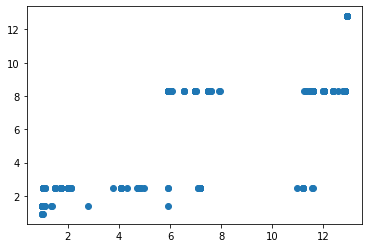

In [130]:
eval_loader = DataLoaders.sigmoid_circuit(100, 100)
input_batch, target_batch = eval_loader.first()

with torch.no_grad():
    network.eval()
    out = network(input_batch)
target_batch.x
out.x
    
import pylab as plt

plt.scatter(target_batch.x.numpy(), out.x.numpy())

In [ ]:
core().forward